In [242]:
import xarray as xr
from matplotlib import pyplot as plt
import os
import netCDF4
import pandas as pd
import datetime
import numpy as np
import scipy
from scipy.signal import argrelextrema
import seaborn as sns

In [192]:
from scipy.signal import argrelextrema
# for local maxima
def MAXMIN(BD,Var):
    """ 'Find local maxima and minima and calculates the difference between them  """
    BD['hour']=BD.index.hour
    vari=BD[Var].to_numpy()
    argrelextrema(vari, np.greater)
    # for local minima
    if Variable=='TSSM_CON@':
        order1=1
        order2=1
    elif Variable=='w':
        order1=3
        order2=4
    elif Variable=='wr':
        order1=4
        order2=3 
    else:
        order2=6
        order1=4
    MINI=BD[Var].iloc[argrelextrema(vari, np.less_equal,order=order1)].to_numpy()
    MAXI=BD[Var].iloc[argrelextrema(vari, np.greater_equal,order=order2)].to_numpy()
    tMINI=BD[['hour',Var]].iloc[argrelextrema(vari, np.less_equal,order=order1)];tMINI['Ext']='Min'
    tMAXI=BD[['hour',Var]].iloc[argrelextrema(vari, np.greater_equal,order=order2)];tMAXI['Ext']='Max'
    tMINIidx=tMINI.index
    tMAXIidx=tMAXI.index
    H=pd.concat([tMINI,tMAXI]).sort_index()
    H.loc[tMAXIidx]
    H[r'$\Delta$']=H[Var].diff()
    H['time']=H.index.to_series().diff()
    H[r'$\Delta t$']=H['time'].apply(lambda x:x.seconds/3600)
    H['Station']=StationT[k]
    return H
def WindDir(x,y):
    A=np.rad2deg(np.arctan2(y, x))
    # result=np.zeros(len(x))
    for i in range(len(A)):
            a=A[i]
            if  a>90:
                A[i]=180+a
            else:
                A[i]=90-a
    return(A)
def QQ(BD,Var,f):
    if f==0:
        fun='max'
    elif f==1:
        fun='min'
    #Taking all the temperatures for the same month and day
    BD['year']=BD.index.year
    BD['month']=BD.index.month
    BD['day']=BD.index.day
    BD['hour']=BD.index.hour
    #1.  Calculating $\bar{t}(\tau_{i+1})
    BD[Var]=BD.groupby(['month','day','hour'])[Var].transform(fun)
    MC,Count,STD=[],[],[]
    BD['sum']=BD.groupby(['month','day'])[Var].transform('sum')
    BD['count']=BD.groupby(['month','day'])[Var].transform('count') 
    BD[r'$\bar{T}(\tau_{i+1})$']=BD.groupby(['month','day'])[Var].transform('mean')  
def Aver3(Ju):
    a=Ju.iloc[0:-2]
    b=Ju.iloc[1:-1]
    c=Ju.iloc[2::]
    n=a['count'].values+b['count'].values+c['count'].values
    mean=(a['sum'].values+b['sum'].values+c['sum'].values)
    mean=np.append(mean[0],mean);mean=np.append(mean, mean[-1])
    n=np.append(n[0],n);n=np.append(n, n[-1])
    Ju['sum2']=mean;Ju['count2']=n
    print(np.shape(n))
    Ju[r'$\bar{T}(\tau_{i+1})$']=Ju.groupby(['month','day']).transform('sum')['sum2']/Ju.groupby(['month','day']).transform('sum')['count2']
    Ju['std']=np.power(Ju[r'$\Delta$'].values-Ju[r'$\bar{T}(\tau_{i+1})$'].values,2)
    a=Ju.iloc[0:-2]
    b=Ju.iloc[1:-1]
    c=Ju.iloc[2::]
    mean=(a['std'].values+b['std'].values+c['std'].values);mean=np.append(mean[0],mean);mean=np.append(mean, mean[-1])
    Ju['std']=mean
    Ju['S1']=(Ju.groupby(['month','day']).transform('sum')['std']/Ju.groupby(['month','day']).transform('sum')['count2'])
    Ju['std']=Ju['S1']**(1/2)
    return Ju
                                                                                                                       

In [193]:
Path='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/DATAfromIdeam/RADICADO_20229050002332/'
StationT=['21235030','21255160','21185090','21115180','21235010']
def Temperature(k):
    Variable='TA2_AUT_60@'
    if StationT[k]=='21235010':
         Variable='TSSM_CON@'
    T=pd.read_csv(Path+Variable+StationT[k]+'.data',delimiter='|',parse_dates=True,header=0,names=['time','Temperature'],index_col='time')
    T['Temperature'].replace(0,np.nan,inplace=True)
    #Taking all the temperatures for the same month and day
    T[T['Temperature']==0]
    T.index.to_series().diff()
    F=MAXMIN(T,'Temperature')
    F=F[(F[r'$\Delta t$']>4)&(F[r'$\Delta t$']<21)] #
    F=F[F['Ext']=='Max']
    variable=r'$\dot{T}$'
    variable=r'$\Delta$'
    QQ(F,r'$\Delta$',0)
    F['std']=F.groupby(['month','day'])[variable].transform('std')
    # F['count']=F.groupby(['month','day'])[variable].transform('count').transform(np.sqrt)
    F[(F['month']==1)&(F['day']==1)]###Quitar para GIThub
    F[r'$\dot{T}$']=F[r'$\Delta$']/F[r'$\Delta t$']
    Aver3(F)  
    F.count()
    F[r'$q-\bar{q}$']=F[r'$\Delta$']-F[r'$\bar{T}(\tau_{i+1})$']
    #Calculating sigma
    g=1
    #Applying hypothesis
    FF=F[F[r'$q-\bar{q}$']>=F['std']*g*1]
    FF.sort_values(by=r'$\Delta$')
    H1T=FF
    return H1T
def RH(k):
    Variable='HRA2_AUT_60@'
    StationRH=['21235030','21255160','21185090','21115180','21235010']
    if StationRH[k]=='21235010':
         Variable='HR_CAL@'
    HR=pd.read_csv(Path+Variable+StationRH[k]+'.data',delimiter='|',parse_dates=True,header=0,names=['time','Relative Humidity (%)'],index_col='time')
    HR['Relative Humidity (%)'].replace(0,np.nan,inplace=True)
    HR['Relative Humidity (%)'].replace(1.0,np.nan,inplace=True)
    G=MAXMIN(HR,'Relative Humidity (%)')
    G=G[G[r'$\Delta t$']>4]
    G=G[G['Ext']=='Min']
    QQ(G,r'$\Delta$',1)
    variable=r'$\Delta$'
    G.rename(columns={r'$\dot{T}$':r'$\dot{RH}$'},inplace=True)
    G['std']=G.groupby(['month','day'])[variable].transform('std')
    G[r'$\dot{RH}$']=G[r'$\Delta$']/G[r'$\Delta t$']
    Aver3(G)  
    G.rename(columns={r'$\bar{T}(\tau_{i+1})$':r'$\bar{RH}(\tau_{i+1})$'},inplace=True)
    G[r'$q-\bar{q}$']=G[r'$\Delta$']-G[r'$\bar{RH}(\tau_{i+1})$']
    #Calculating sigma
    g=1
    #Applying hypothesis
    GG=G[-1*G[r'$q-\bar{q}$']>=G['std']*g*1]
    G.sort_values(by=r'$\Delta$')
    H1RH=GG
    return H1RH
def MERGE(H1RH,H1T):
    H124=np.intersect1d(H1RH.index.date,H1T.index.date)#With amplitudes
    return H124

In [194]:
def Velocity(H12,H1RH,H1T):
    #If the variable is Wind direction of maximum speed (DVMX_MX_D)
    Path='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/DATAfromIdeam/RADICADO_20229050002332/'
    Variable='DVMX_MX_D@'
    StationDV='21206920'
    theta=32
    DV=pd.read_csv(Path+Variable+StationDV+'.data',delimiter='|',parse_dates=True,header=0,names=['time','Direction'],index_col='time')
    H1DV=DV[(DV['Direction']<135+theta)&(DV['Direction']>theta+45)].index.date
    B=H1RH.copy();B.index=B.index.date
    A=H1T.copy();A.index=A.index.date
    data11=A.loc[np.intersect1d(H12,H1DV)].drop_duplicates()
    data12=B.loc[np.intersect1d(H12,H1DV)].drop_duplicates()
    data11[[r'$\dot{RH}$',r'$\Delta RH$']]=data12[[r'$\dot{RH}$',r'$\Delta$']]
    data11[r'$\dot{RH}$']=data12[r'$\dot{RH}$']
    data11.to_csv(StationT[k]+'DV'+StationDV+'.csv')
    #If the variable is Wind direction of maximum speed (DVMX_MX_D)
    Path='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/DATAfromIdeam/RADICADO_20229050002332/'
    Variable='DVMX_AUT_60@'
    StationDV='21195170'
    theta=32
    DV=pd.read_csv(Path+Variable+StationDV+'.data',delimiter='|',parse_dates=True,header=0,names=['time','Direction'],index_col='time')
    H1DV=DV[(DV['Direction']<135+theta)&(DV['Direction']>theta+45)].index.date
    B=H1RH.copy();B.index=B.index.date
    A=H1T.copy();A.index=A.index.date
    data21=A.loc[np.intersect1d(H12,H1DV)].drop_duplicates()
    data22=B.loc[np.intersect1d(H12,H1DV)].drop_duplicates()
    data21[[r'$\dot{RH}$',r'$\Delta RH$']]=data22[[r'$\dot{RH}$',r'$\Delta$']]
    data21[r'$\dot{RH}$']=data22[r'$\dot{RH}$']
    data21.to_csv(StationT[k]+'DV'+StationDV+'.csv')

In [195]:
for k in range(5):
    H11T=Temperature(k)
    H11RH=RH(k)
    H124=MERGE(H11T,H11RH)
    Velocity(H124,H11RH,H11T)

(3901,)
(3525,)
(4817,)
(4256,)
(3861,)
(2976,)
(2975,)
(2004,)
(11004,)
(10084,)


In [196]:
import glob
from functools import reduce
Casos= [f for f in glob.glob("*DV*")]
Cases=[]
for i in Casos:
    j = pd.read_csv(i,index_col=0,parse_dates=True)
    Cases.append(j)

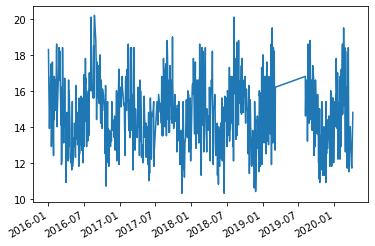

In [271]:
Foehn=pd.concat(Cases)
Foehn=Foehn.drop_duplicates()
Foehn = Foehn.sort_values(by=r'$\Delta$', ascending=False)
Foehn['N cases']=Foehn.groupby(['month','day','year']).transform('count')['hour']
Foehn = Foehn[~Foehn.index.duplicated(keep='first')]#Dropping duplicates, keeping highest value of delta T
Foehn['2016':'2019']
Foehn=Foehn[Foehn[r'$\Delta$']<21]
Foehn[r'$\Delta$']['2016':'2020'].plot()
# Foehn['2019-08-27']
Foehn=H124

In [270]:
Foehn[r'$\Delta$']['2016':'2020'].hist()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Foehn[r'$\Delta RH$']['2016':'2019'].hist()
Foehn[r'$\Delta RH$']['2016':'2019'].describe()
Foehn[Foehn[r'$\Delta$']>14]['2016':'2019']['month'].hist()

In [267]:
Foehn[r'$\Delta$']['2016':'2020'].describe()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fd7032130>]],
      dtype=object)

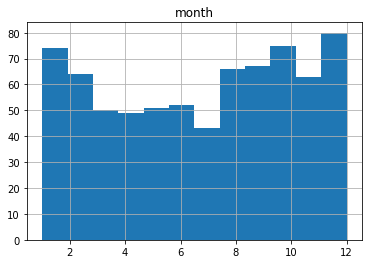

In [258]:
Foehn['2016':'2019'].hist('month',bins=12)

In [259]:
Foehn['2016':'2019'].groupby('month').count()

,hour,Temperature,Ext,$\Delta$,time,$\Delta t$,Station,year,day,sum,...,$\bar{T}(\tau_{i+1})$,std,$\dot{T}$,sum2,count2,S1,$q-\bar{q}$,$\dot{RH}$,$\Delta RH$,N cases
month,,,,,,,,,,,,,,,,,,,,,
1,74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74
2,64,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
3,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
4,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
5,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
6,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
7,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
8,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
9,67,67,67,67,67,67,67,67,67,67,...,67,67,67,67,67,67,67,67,67,67


In [249]:
Foehn['2018-07-14']

<ipython-input-249-41263f9ae502>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  Foehn['2018-07-14']


,hour,Temperature,Ext,$\Delta$,time,$\Delta t$,Station,year,month,day,...,$\bar{T}(\tau_{i+1})$,std,$\dot{T}$,sum2,count2,S1,$q-\bar{q}$,$\dot{RH}$,$\Delta RH$,N cases
2018-07-14,14,37.1,Max,17.3,0 days 08:00:00,8.0,21185090,2018,7,14,...,13.881212,1.411816,2.1625,386.9,30,1.993225,3.418788,-9.5,-57.0,3
